# Goal: Historical data about students' scores is provided. The goal is to build a predictive model to 

# --------------------
# packages
# --------------------

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# -----------------
# Data load
# -----------------

In [4]:
filePath = 'test_scores.csv'
df = pd.read_csv(filePath)
df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


# --------------------------
# Data Exploration
# --------------------------

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2133 entries, 0 to 2132
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           2133 non-null   object 
 1   school_setting   2133 non-null   object 
 2   school_type      2133 non-null   object 
 3   classroom        2133 non-null   object 
 4   teaching_method  2133 non-null   object 
 5   n_student        2133 non-null   float64
 6   student_id       2133 non-null   object 
 7   gender           2133 non-null   object 
 8   lunch            2133 non-null   object 
 9   pretest          2133 non-null   float64
 10  posttest         2133 non-null   float64
dtypes: float64(3), object(8)
memory usage: 183.4+ KB


### School

In [6]:
df['school'].value_counts()

GOOBU    158
QOQTS    149
UKPGS    128
DNQDD    122
GJJHK    118
ZOWMK    117
VVTVA    114
KZKKE    111
CCAAW    109
CUQAM    107
VKWQH    100
IDGFP     94
UAGPU     87
UUUQX     84
OJOBU     81
CIMBB     74
ZMNYA     69
GOKXL     64
LAYPA     57
KFZMY     52
VHDHF     51
FBUMG     46
ANKYI     41
Name: school, dtype: int64

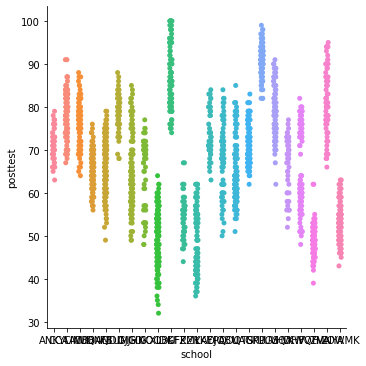

In [7]:
sns.catplot(x="school", y="posttest", data=df)

<AxesSubplot:xlabel='school', ylabel='posttest'>

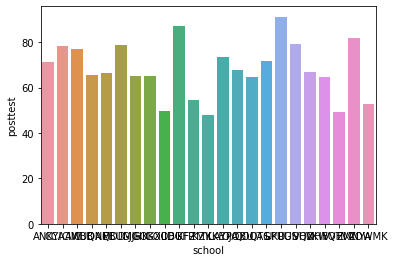

In [8]:
sns.barplot(x = 'school', y = 'posttest',data=df.groupby('school')['posttest'].mean().reset_index())

### School Setting

In [9]:
df['school_setting'].value_counts()

Urban       906
Suburban    717
Rural       510
Name: school_setting, dtype: int64

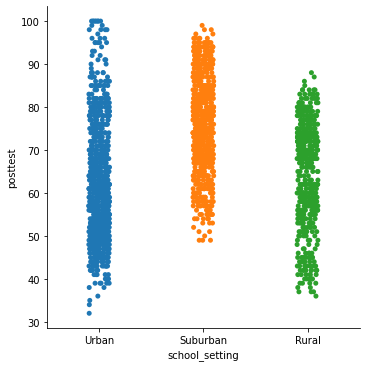

In [10]:
sns.catplot(x="school_setting", y="posttest", data=df)

### School type

In [11]:
df['school_type'].value_counts()

Public        1582
Non-public     551
Name: school_type, dtype: int64

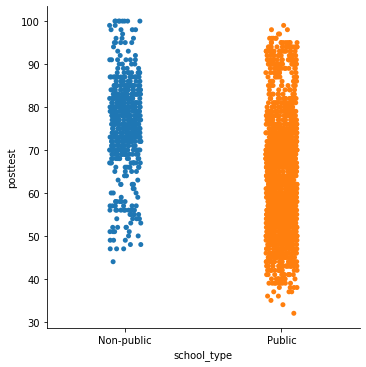

In [12]:
sns.catplot(x="school_type", y="posttest", data=df)

### Classroom

In [13]:
df['classroom'].value_counts()

18K    31
ZBH    30
Q0E    30
QA2    30
A93    30
       ..
KR1    15
IQN    15
SSP    15
197    14
JGD    14
Name: classroom, Length: 97, dtype: int64

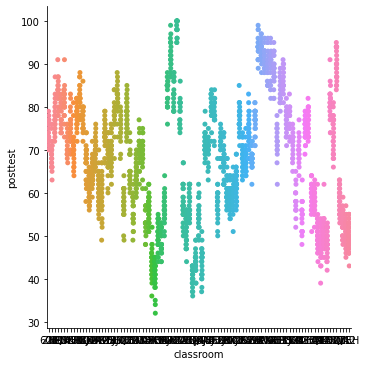

In [14]:
sns.catplot(x="classroom", y="posttest", data=df)

##### Note : 97 unique values, also difficult to understand it's business value, so would ignore this feature primarily

### Teching Method

In [15]:
df['teaching_method'].value_counts()

Standard        1373
Experimental     760
Name: teaching_method, dtype: int64

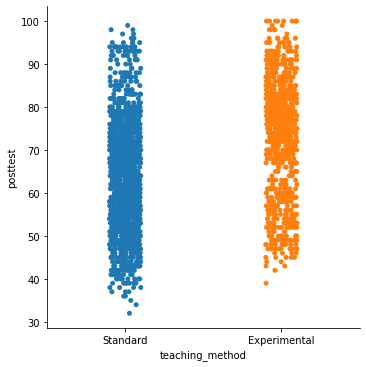

In [16]:
sns.catplot(x="teaching_method", y="posttest", data=df)

### Gender

In [17]:
df['gender'].value_counts()

Male      1077
Female    1056
Name: gender, dtype: int64

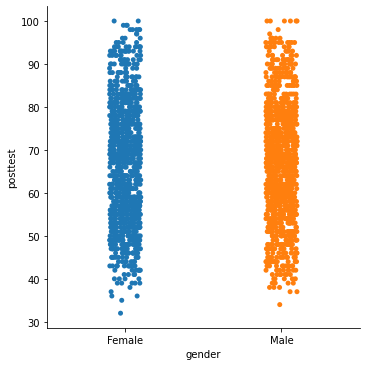

In [18]:
sns.catplot(x="gender", y="posttest", data=df)

#### Note :  posttest distribution is almost same for both the genders, so we can neglect this feature

### Lunch

In [19]:
df['lunch'].value_counts()

Does not qualify                    1215
Qualifies for reduced/free lunch     918
Name: lunch, dtype: int64

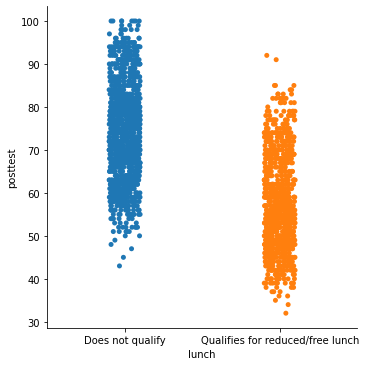

In [20]:
sns.catplot(x="lunch", y="posttest", data=df)

### Correlation Among Numerical Features

In [21]:
df.corr()

,n_student,pretest,posttest
n_student,1.000000,-0.499253,-0.504886
pretest,-0.499253,1.000000,0.950884
posttest,-0.504886,0.950884,1.000000


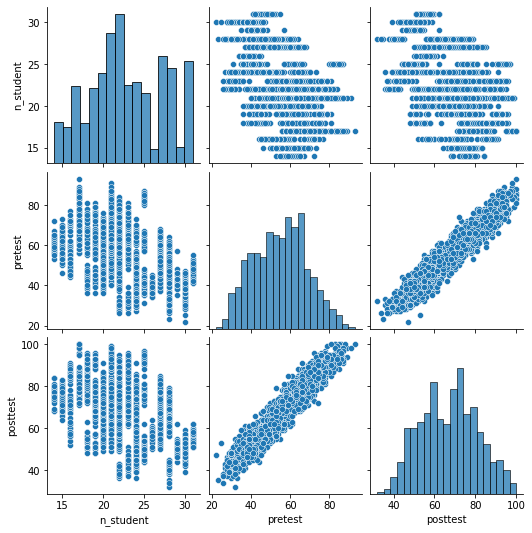

In [22]:
sns.pairplot(df)

#### Note : Correlation value between n_students and pretest is not strong enough to discard one component

### Dropping redundant columns

In [23]:
df  = df.drop(['gender','school','classroom','student_id'],axis=1)

In [24]:
df.columns

Index(['school_setting', 'school_type', 'teaching_method', 'n_student',
       'lunch', 'pretest', 'posttest'],
      dtype='object')

# ---------------------------
# Data Preparation
# ---------------------------

In [25]:
#Split between Train and Test set
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
print("Train Set size: ",len(train_set))
print("Test Set size: ",len(test_set))

Train Set size:  1706
Test Set size:  427


In [27]:
X_train = train_set.drop(['posttest'],axis=1)
y_train = train_set['posttest']

X_test = test_set.drop(['posttest'],axis=1)
y_test = test_set['posttest']

In [28]:
# Custom Transformer, Based on given column names filter in data frames
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [29]:
#Categorical Attributes in the given dataset, and apply OneHot Encoding on these columns through pipeline

cat_attribs = ['school_setting','school_type','teaching_method','lunch']
cat_pipeline = Pipeline([
                    ('selector', DataFrameSelector(cat_attribs)),
                    ('one_hot_encoder', OneHotEncoder(sparse=False)),
                ])

In [30]:
#Numerical Attributes in our dataframe, Scaling applied for faster convergence of algorithm
num_attribs = ['n_student','pretest']
num_pipeline = Pipeline([
                         ('selector', DataFrameSelector(num_attribs)),
                         ('std_scaler', StandardScaler()),
                        ])

In [31]:
#Complete Transformation Pipeline
full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
])

In [32]:
#Data ready for use in algorithm after transformation
X_train = full_pipeline.fit_transform(X_train)
X_train

array([[-1.13943179,  0.89592935,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [-0.66380893,  0.96988211,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.28743679, -1.61846421,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.90162036,  0.37826009,  1.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.18818607, -0.43522018,  0.        , ...,  1.        ,
         1.        ,  0.        ],
       [-0.18818607,  1.26569311,  0.        , ...,  1.        ,
         1.        ,  0.        ]])

In [33]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(1706, 11)


# --------------------------
# Model Selection
# --------------------------

## Linear Regression Model

In [34]:
lin_reg = LinearRegression()

## Random Forest Regression Model

In [35]:
forest_reg = RandomForestRegressor()

## Cross Validation

In [36]:
y_train.describe()

count    1706.000000
mean       67.046307
std        13.936794
min        32.000000
25%        56.000000
50%        68.000000
75%        77.000000
max       100.000000
Name: posttest, dtype: float64

In [37]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def checkModelPerformance(reg, X_train,y_train, n_CV = 10):
    scores = cross_val_score(reg, X_train, y_train,
    scoring="neg_mean_squared_error", cv=n_CV)
    rmse_scores = np.sqrt(-scores)
    display_scores(rmse_scores)

In [38]:
checkModelPerformance(lin_reg,X_train,y_train)

Scores: [3.08438777 3.33730575 3.49782756 3.38287523 3.0878775  3.29949545
 3.2629347  3.20065614 2.72710947 3.16952003]
Mean: 3.204998958559286
Standard deviation: 0.20127102360079932


In [39]:
checkModelPerformance(forest_reg,X_train,y_train)

Scores: [3.24768086 3.36678694 3.28116304 3.29699873 3.23177754 3.52348341
 3.45649889 3.49469527 2.89019196 3.51590111]
Mean: 3.3305177736909015
Standard deviation: 0.18160437401084115


## Both the models performs good enough to be considered, I would choose Linear regressor, as using cross validation the mean score is lesser and this model is simpler compared to RandomForest

## --------------------------
# Model Training
## --------------------------

In [40]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# ------------------------------------------------
# Model Performance on Test Set
# ------------------------------------------------

In [41]:
X_test = full_pipeline.transform(X_test)
final_predictions = model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Error on Test data : ",final_rmse)

Error on Test data :  3.247733030338314


In [42]:
print ("Explained Variance : ",explained_variance_score(test_set['posttest'], final_predictions))
print ("R2 score : ",r2_score(test_set['posttest'], final_predictions))

Explained Variance :  0.9475730478313101
R2 score :  0.947560651804069


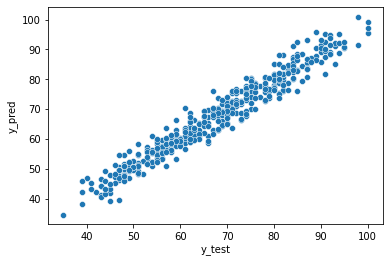

In [43]:
ax = sns.scatterplot(x=y_test,y=final_predictions)
ax.set(xlabel='y_test', ylabel='y_pred')
plt.show()

In [44]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))